# QSAR Oral Toxicity Dataset - Lab 8

In [1]:
import ds_functions as ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, validation_curve
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from imblearn.over_sampling import SMOTE
from subprocess import call
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, mutual_info_classif, f_classif, f_regression, VarianceThreshold
import seaborn as sns
import  mlxtend.frequent_patterns as pm

In [2]:
data: pd.DataFrame = pd.read_csv('datasets/qsar_oral_toxicity_v2.csv')
target = 'IS_TOXIC'
original_data = data.copy()
data_unbalanced = data.copy()

#### \[No Normalization Needed]

### Balancing

In [3]:
def balancing(trnX, trnY, undersample, oversample):
    #undersample, oversample = 1,0 => undersample
    #undersample, oversample = 0,1 => oversample
    unique, counts = np.unique(trnY, return_counts=True)
    
    min_positive_counts = min(counts)
    min_negative_counts = max(counts)+(min(counts)-max(counts))*undersample
    newtrnY: np.ndarray = []
    newtrnX: np.ndarray = []
    for idx in range(len(trnY)):
        if min_positive_counts > 0 and trnY[idx] == 1:
            newtrnY.append(trnY[idx])
            newtrnX.append(trnX[idx])
            min_positive_counts -= 1
        elif min_negative_counts > 0 and trnY[idx] == 0:
            newtrnY.append(trnY[idx])
            newtrnX.append(trnX[idx])
            min_negative_counts -= 1
            
    unique1, counts1 = np.unique(newtrnY, return_counts=True)
    
    max_positive_counts = min(counts1)+(max(counts1)-min(counts1))*oversample
    max_negative_counts = max(counts1)
    finaltrnY: np.ndarray = []
    finaltrnX: np.ndarray = []
    negX: np.ndarray = []
    posX: np.ndarray = []
    negY: np.ndarray = []
    posY: np.ndarray = []
        
    for idx in range(len(newtrnY)):
        if newtrnY[idx] == 0:
            finaltrnY.append(newtrnY[idx])
            negY.append(newtrnY[idx])
            finaltrnX.append(newtrnX[idx])
            negX.append(newtrnX[idx])
            max_negative_counts -= 1
        elif newtrnY[idx] == 1:
            finaltrnY.append(newtrnY[idx])
            posY.append(newtrnY[idx])
            finaltrnX.append(newtrnX[idx])
            posX.append(newtrnX[idx])
            max_positive_counts -= 1

    random.seed()

    while max_negative_counts > 0:
        rand_num = random.randint(0,len(negX)-1)
        finaltrnX.append(negX[rand_num])
        finaltrnY.append(negY[rand_num])
        max_negative_counts -= 1

    while max_positive_counts > 0:
        rand_num = random.randint(0,len(posX)-1)
        finaltrnX.append(posX[rand_num])
        finaltrnY.append(posY[rand_num])
        max_positive_counts -= 1
    
    return finaltrnX, finaltrnY

In [4]:
def balancing_v1(data_frame):
    data_frame_to_modify = data_frame.copy()
    target_count = data_frame_to_modify[target].value_counts()
    min_class = target_count.idxmin()
    ind_min_class = target_count.index.get_loc(min_class)

    RANDOM_STATE = 50
    values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

    df_class_min = data_frame_to_modify[data_frame_to_modify[target] == min_class]
    df_class_max = data_frame_to_modify[data_frame_to_modify[target] != min_class]

    df_under = df_class_max.sample(len(df_class_min), random_state=RANDOM_STATE)
    values['UnderSample'] = [target_count.values[ind_min_class], len(df_under)]
    df_over = df_class_min.sample(len(df_class_max), replace=True, random_state=RANDOM_STATE)
    values['OverSample'] = [len(df_over), target_count.values[1-ind_min_class]]
    smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
    y = data_frame_to_modify.pop(target).values
    X = data_frame_to_modify.values
    smote_X, smote_y = smote.fit_sample(X, y)
    smote_target_count = pd.Series(smote_y).value_counts()
    values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

    over_sampled = pd.concat([df_over, df_class_max])
    under_sampled = pd.concat([df_under, df_class_min])
    
    return over_sampled, under_sampled

In [5]:
over_sampled, under_sampled = balancing_v1(data_unbalanced)
under_sampled.pop(target)
under_sampled

,MOL_FIG1,MOL_FIG2,MOL_FIG3,MOL_FIG4,MOL_FIG5,MOL_FIG6,MOL_FIG7,MOL_FIG8,MOL_FIG9,MOL_FIG10,...,MOL_FIG1015,MOL_FIG1016,MOL_FIG1017,MOL_FIG1018,MOL_FIG1019,MOL_FIG1020,MOL_FIG1021,MOL_FIG1022,MOL_FIG1023,MOL_FIG1024
7281,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
470,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
6435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4012,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6406,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8930,0,0,0,0,0,1,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
8941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=target, axis=1),
    data[target],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((6294, 1024), (2698, 1024))

In [7]:
var_thres=VarianceThreshold(threshold=0.05)
var_thres.fit(X_train)

VarianceThreshold(threshold=0.05)

In [8]:
var_thres.get_support()

array([ True, False,  True, ..., False, False, False])

In [9]:
### Finding non constant features
sum(var_thres.get_support())

430

In [10]:
# Lets Find non-constant features 
len(X_train.columns[var_thres.get_support()])

430

In [8]:
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[var_thres.get_support()]]

print(len(constant_columns))

594


In [12]:
'''
for column in constant_columns:
    print(column)
'''

'\nfor column in constant_columns:\n    print(column)\n'

In [9]:
X_train.drop(constant_columns,axis=1)

,MOL_FIG1,MOL_FIG3,MOL_FIG6,MOL_FIG7,MOL_FIG8,MOL_FIG11,MOL_FIG13,MOL_FIG14,MOL_FIG15,MOL_FIG16,...,MOL_FIG1001,MOL_FIG1004,MOL_FIG1005,MOL_FIG1008,MOL_FIG1009,MOL_FIG1010,MOL_FIG1011,MOL_FIG1016,MOL_FIG1018,MOL_FIG1019
993,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3054,1,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1136,1,0,0,0,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3774,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
6384,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7891,0,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3264,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0


**Feature Selection**

min 0.565

In [10]:
MIN_SUP: float = 0.6
var_min_sup =[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1] #+ [i*MIN_SUP for i  in range(100, 0, -10)]

847 patterns


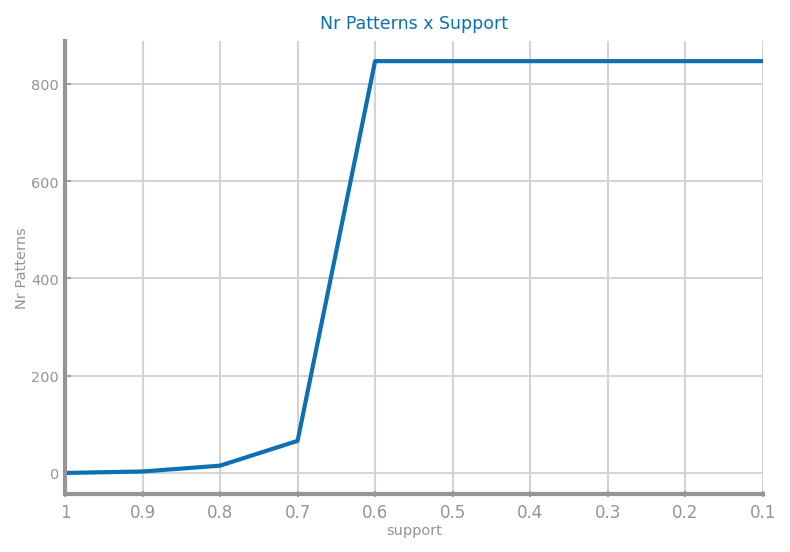

In [11]:
patterns: pd.DataFrame = pm.fpgrowth(X_train, min_support=MIN_SUP, use_colnames=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

plt.figure(figsize=(6, 4))
ds.plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
plt.show()

In [16]:
MIN_CONF: float = 0.6
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 25182 rules


In [17]:
MIN_CONF: float = 0.7
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 24919 rules


In [18]:
MIN_CONF: float = 0.8
rules = pm.association_rules(patterns, metric='confidence', min_threshold=MIN_CONF, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 24133 rules


In [20]:
def plot_top_rules(rules: pd.DataFrame, metric: str, per_metric: str) -> None:
    _, ax = plt.subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    plt.show()

def analyse_per_metric(rules: pd.DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)
    ds.multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    ds.multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    plt.show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

**MIN_SUP: float = 0.59**

Analyse per support...


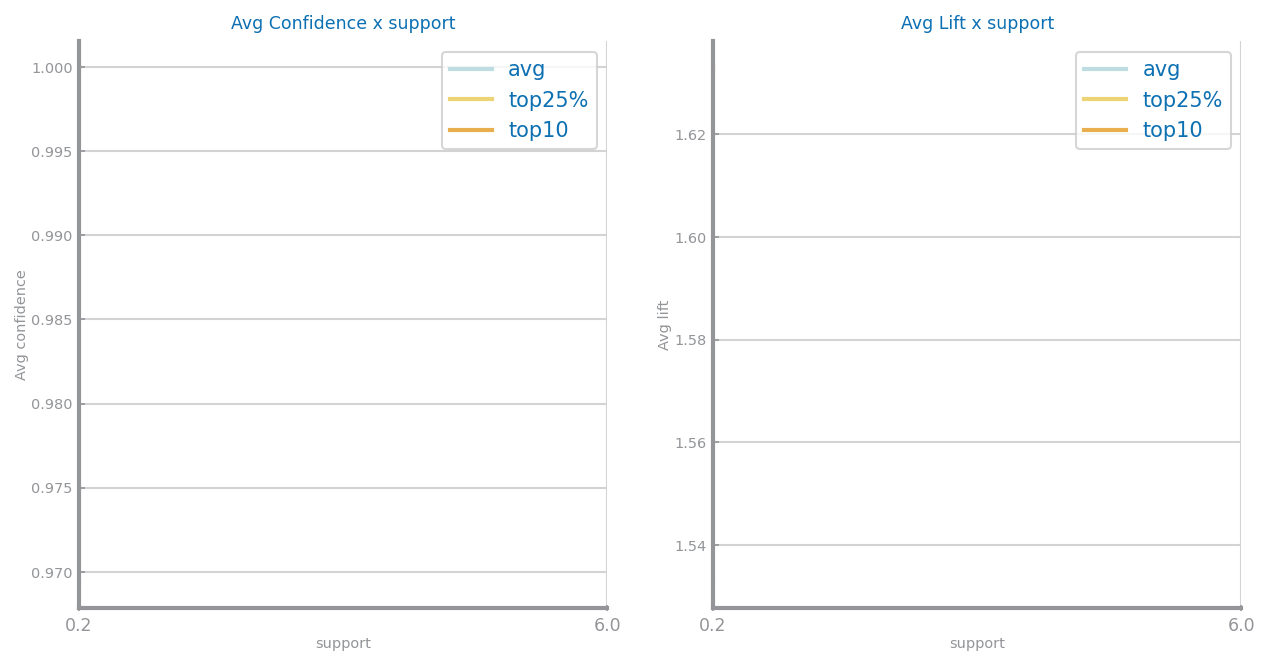

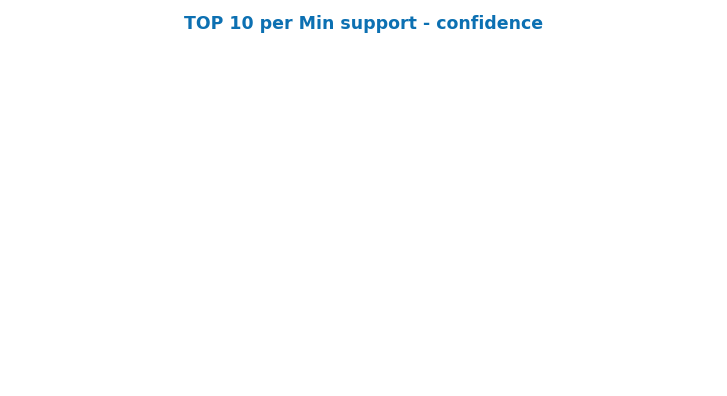

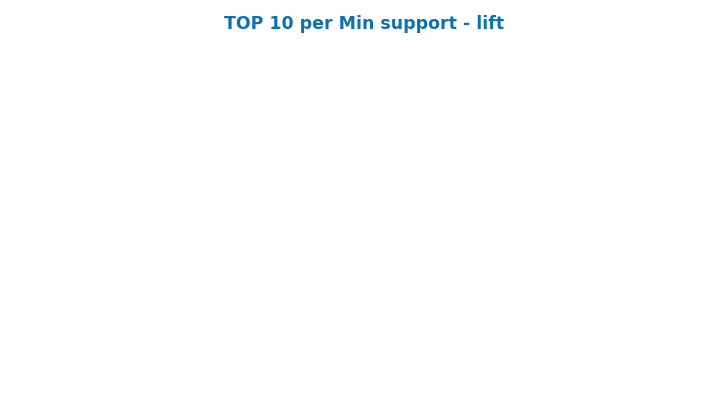

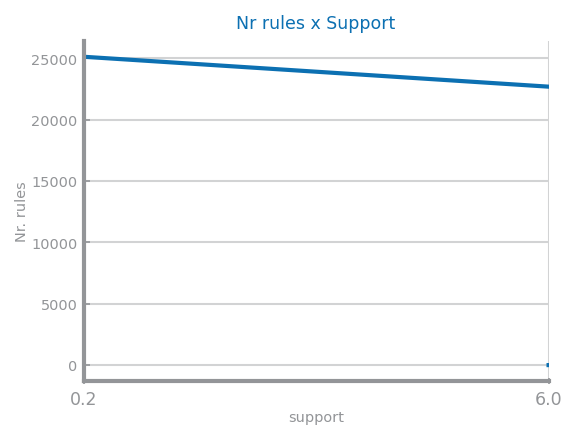

In [17]:
nr_rules_sp = analyse_per_metric(rules, 'support', var_min_sup)
ds.plot_line(var_min_sup, nr_rules_sp, title='Nr rules x Support', xlabel='support', ylabel='Nr. rules', percentage=False)

Analyse per confidence...


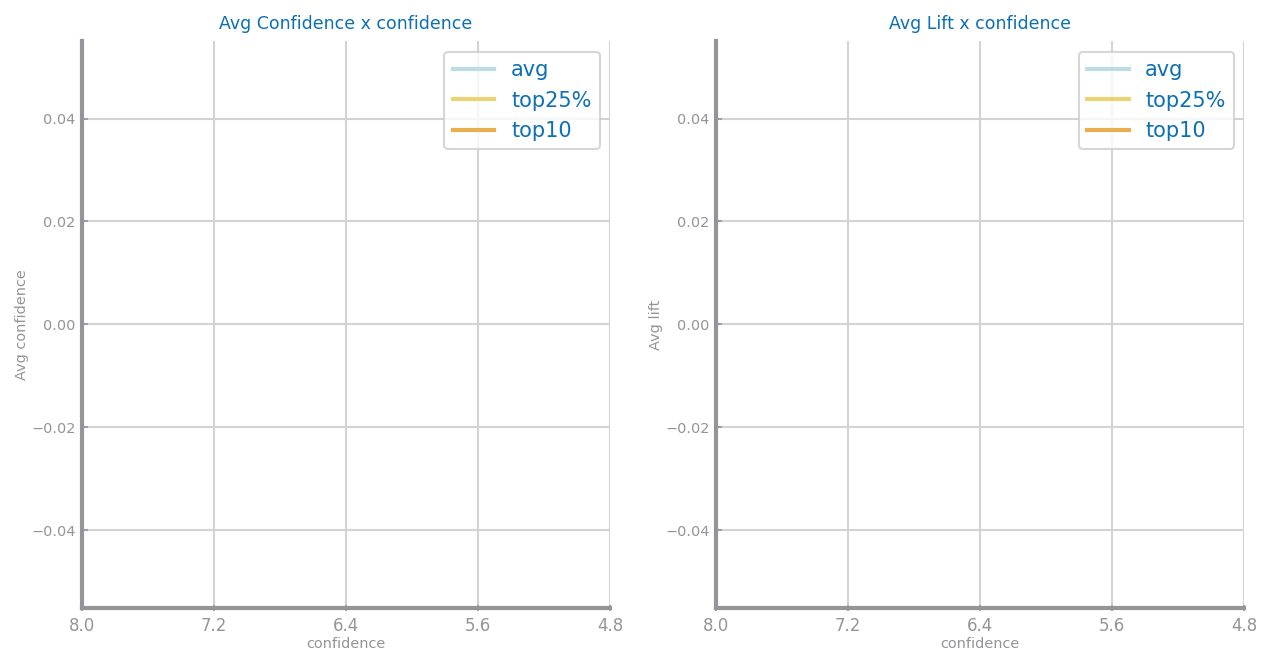

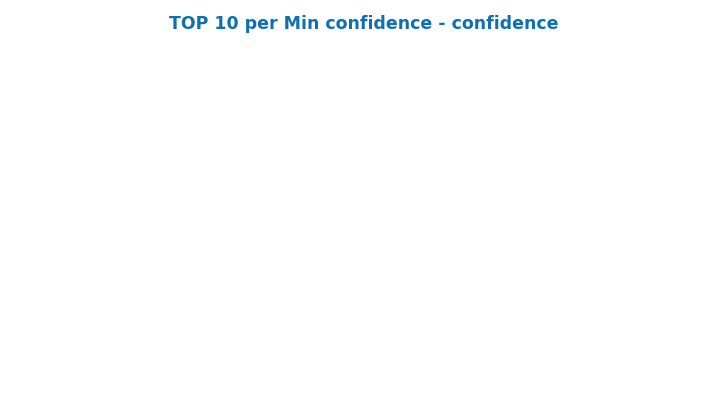

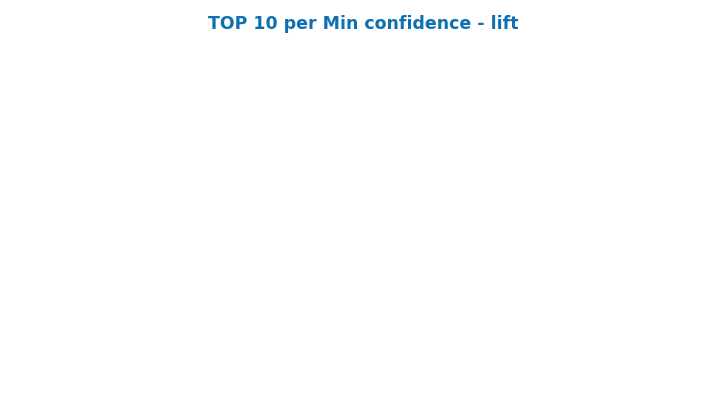

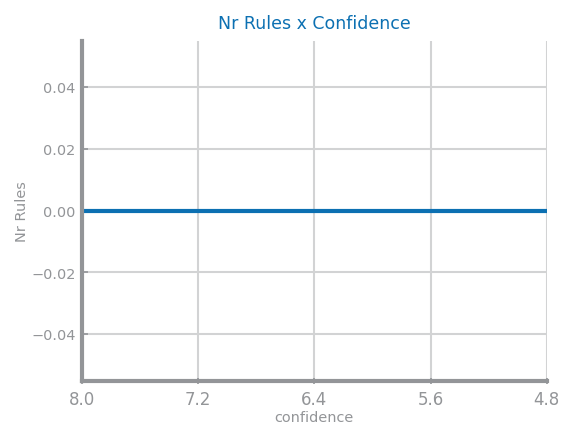

In [21]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
for i in range(len(var_min_conf)):
    var_min_conf[i] = round(var_min_conf[i], 1)
nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)

**20 Vars**

Analyse per support...


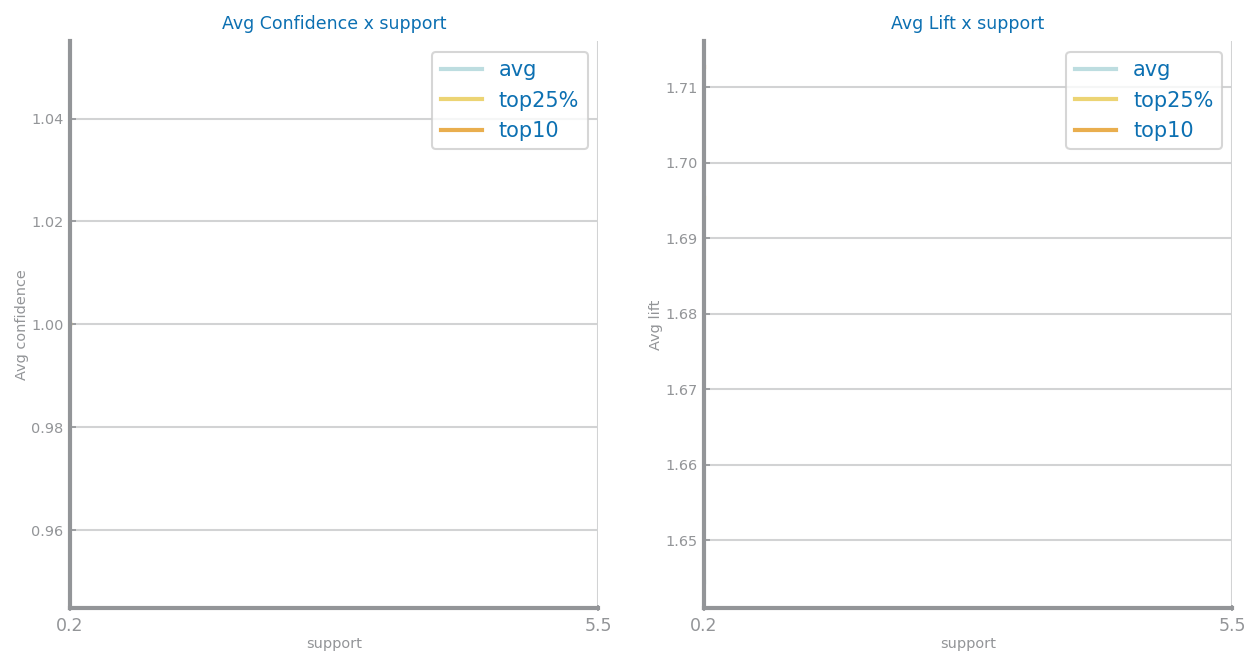

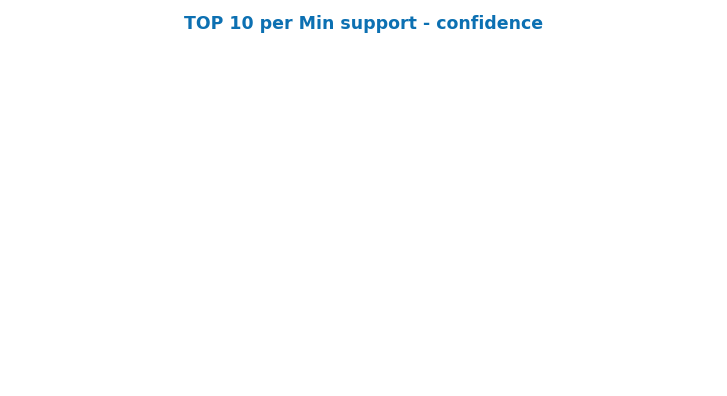

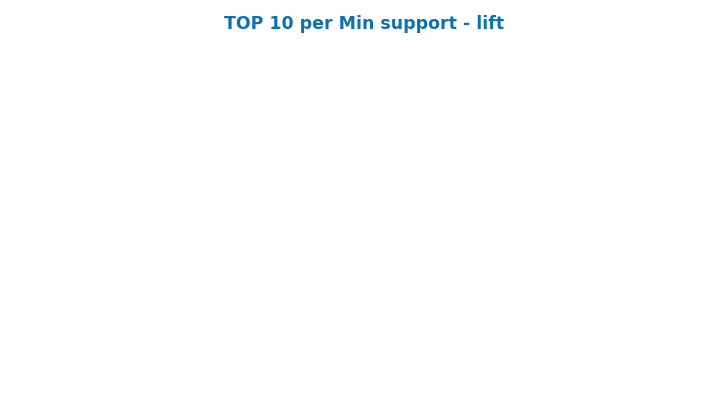

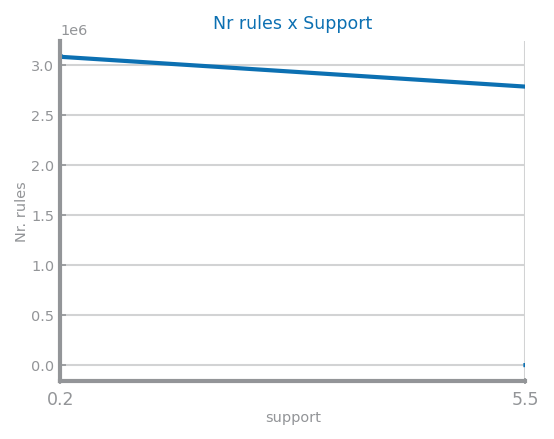

In [22]:
nr_rules_sp = analyse_per_metric(rules, 'support', var_min_sup)
ds.plot_line(var_min_sup, nr_rules_sp, title='Nr rules x Support', xlabel='support', ylabel='Nr. rules', percentage=False)

Analyse per confidence...


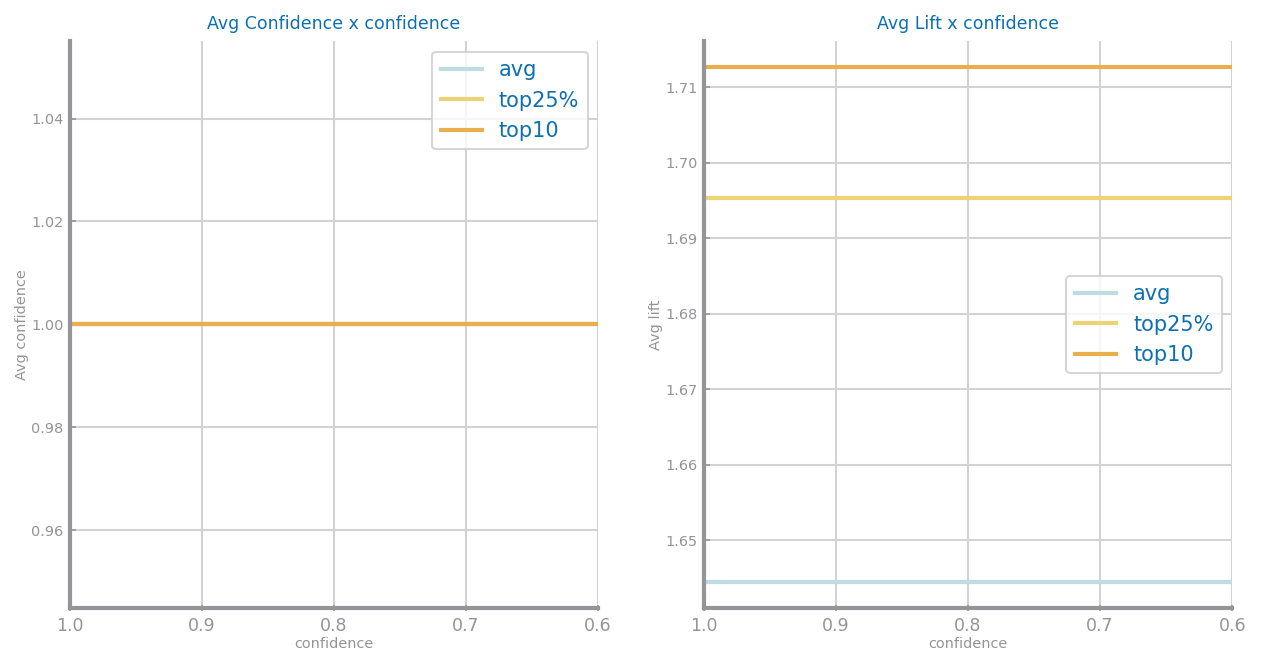

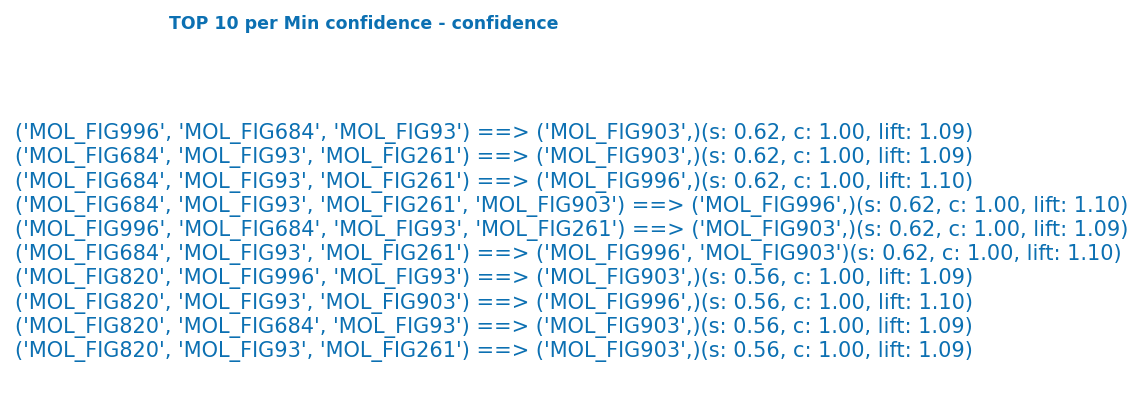

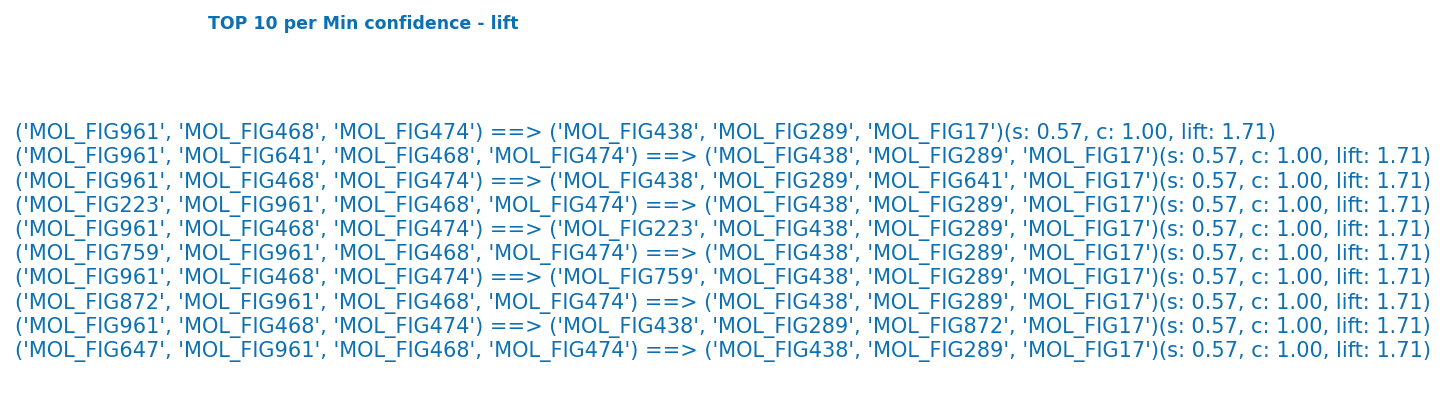

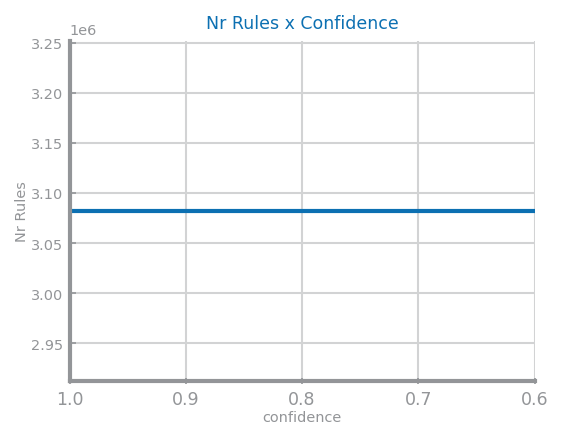

In [23]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
for i in range(len(var_min_conf)):
    var_min_conf[i] = round(var_min_conf[i], 1)
nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
ds.plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)

Apriori execution time: 149.45137977600098
FPGrowth execution time: 1.3320691585540771
Efficiency: 0.008913060291250533


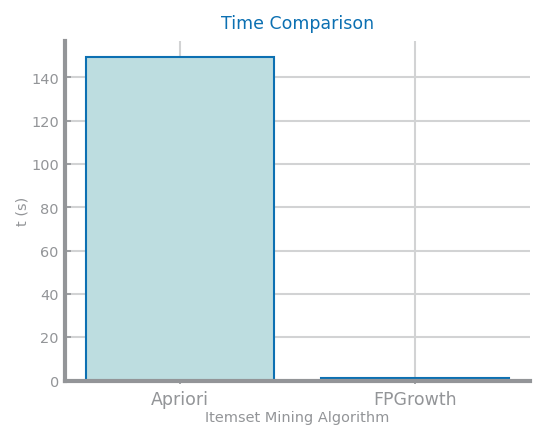

In [21]:
start_time = time.time()
pm.apriori(X_train, min_support=0.55, use_colnames=True)
time_apriori = time.time() - start_time

start_time = time.time()
pm.fpgrowth(X_train, min_support=0.55, use_colnames=True)
time_fpgrowth = time.time() - start_time

print("Apriori execution time: " + str(time_apriori) + "\nFPGrowth execution time: " + str(time_fpgrowth) + "\nEfficiency: " + str(time_fpgrowth/time_apriori))

ds.bar_chart(['Apriori', 'FPGrowth'], [time_apriori, time_fpgrowth], title = 'Time Comparison',
              xlabel = 'Itemset Mining Algorithm', ylabel = 't (s)')